# Project Overview

> This is an in-depth notebook which explores the Austin Housing Dataset through several different models. The notebook includes a thorough EDA and cleaning section, natural language processing on text descriptions, exploration of different models using different categorical methods (one-hot encoding vs target encoding) with extensive parameter tuning, an evaluation of the final model, and visualizations.

* **Business Objective**


* **Notebook Preparation**
    * Importing our Modules


* **Preprocessing**
    * EDA and Cleaning
        * Scaling target value for Time Series
        * Duplicates
        * Outlier Detection
        * Missing Data
        * Binary Data
        * Studying our Target Variable
    * Natural Language Processing
    * Create Holdout Set
    * Feature Engineering
    * Correlations and Multicollinearity
    * EDA & Process Train Set
        * Categoricals
        * Continuous
            * Standardize Continuous Data
            * Find Interactions
            * Adding Polynomial Features
        * NLP
    * Process Test Set
        * Categoricals
        * Continuous
        * NLP
    * Create Train/Test Final


* **Model Explorations**
    * Picking our Base Features
    * Linear Regressions
        * Basic LR with Top Features One-Hot Encoded
        * Basic LR with Top Features Target Encoded
        * LR with ALL model features
        * Linear Regression with various Feature Selection Methods
            * Permutation Importance
            * Forward-Backward Selector
            * RFECV
    * Regularization Models
    * K-Nearest Neighbors
    * Support Vector Regression
    * XGBoost Models
        * XGBoost - One Hot Encoded
        * XGBoost - Target Encoded



* **Regression Results and Model Selection**
    * Evaluate results of all attempted models and choose best model


* Visualizations
    * Feature visualizations

* Analysis


# Notebook Preparation

In [1]:
# data processing tools
import pandas as pd
import numpy as np
#from numpy import mean
#from numpy import std
#from math import sqrt
#import itertools
#from collections import Counter

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols
#import scipy.stats as stats
#from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# NLP tools
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Visualization tools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Preprocessing

In [2]:
# load and look at our austin housing data
df = pd.read_csv('listings_cleaned_austin.csv')
df.head()

,price,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,orig_price,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,accessibility,numOfAppliances,numOfParkingFeatures,patioporch,security,waterfront,windowfeatures,community,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,time_series,zip_rank,median_zip,pr_sqft,numOfSchools
0,328625.0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,1,1,1,1,0,0,Single Family,2,2012,305000.0,5,2019-09-02,9,2019,"Coldwell Banker United, Realtors - South Austin",39,0,5,2,1,1,0,1,0,6011.0,2601.0,1,0,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...,4,8,325080.0,126.0,3
1,309233.0,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,1,1,1,1,0,0,Single Family,2,2013,295000.0,1,2020-10-13,10,2020,Agent Provided,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...,3,8,325080.0,175.0,3
2,286036.0,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,1,1,0,1,0,0,Single Family,0,2018,256125.0,1,2019-07-31,7,2019,Agent Provided,2,0,4,1,0,1,0,0,0,7840.0,1478.0,0,2,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...,6,8,325080.0,194.0,4
3,265930.0,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,1,1,1,1,0,0,Single Family,2,2013,240000.0,4,2018-08-08,8,2018,Agent Provided,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...,5,8,325080.0,158.0,3
4,255324.0,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,1,1,0,1,0,0,Single Family,0,2002,239900.0,3,2018-10-31,10,2018,Agent Provided,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg,3,8,325080.0,120.0,3


In [3]:
df.dtypes

price                       float64
zpid                          int64
city                         object
streetAddress                object
zipcode                       int64
description                  object
latitude                    float64
longitude                   float64
propertyTaxRate             float64
garageSpaces                  int64
hasAssociation                int64
hasCooling                    int64
hasGarage                     int64
hasHeating                    int64
hasSpa                        int64
hasView                       int64
homeType                     object
parkingSpaces                 int64
yearBuilt                     int64
orig_price                  float64
numPriceChanges               int64
latest_saledate              object
latest_salemonth              int64
latest_saleyear               int64
latestPriceSource            object
numOfPhotos                   int64
accessibility                 int64
numOfAppliances             

In [4]:
# identifying the categories we will use
categories = ['zipcode', 'yearBuilt', 'hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 'accessibility', 'patioporch', 'security',
          'waterfront', 'windowfeatures', 'community', 'latest_salemonth', 'numOfSchools', 'garageSpaces', 'propertyTaxRate', ]

continuous = ['numPriceChanges', 'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize', 
              'numOfBedrooms', 'numOfStories', 'numOfPhotos', 'numOfAppliances', 'latest_salemonth'] 

## Natural Language Processing

Our data set includes the listing text for each sale. We're going to use Natural Language Processing methods to extract relevant information from the listing text to boost the effectiveness of our model.

We're using spaCy and after basic package installation, we also need to download the english language pipeline.

In [5]:
# Load spaCy with English language processor
nlp = spacy.load("en_core_web_sm")

# add real estate related stop words to default stop word list
nlp.Defaults.stop_words |= {"bedroom", "bathroom","bath","home", "austin", "tx", "pron", "sq", "ft", "rent", "mo",
                            "w", "bed", 'single', 'family', 'contain', 'st', 'dr', 'square', 'foot', 'room', 'square', 'feet',
                            '-pron-', 'garage', 'pflugerville', 'story', '1st', '1story', '2car', '2nd',
                            '2story', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', 'street', 'avenue', 'ave', 
                            'sac', }

In [6]:
# text processing functions for NLP

def text_block_processor(text):
    '''Takes a block of text. Divides block into sentences with words lemmatized.
    Sends each sentence to word processor. Concatenates all words into one string
    If the string contains "zestimate", returns a DEFAULT listing note
    Otherwise returns string of cleaned and processed words from text block
    PARAMETERS:
    block of text
    '''
    
    make_sentences = nlp(text)
    
    sentences_lemmata_list = [sentence.lemma_.lower() for sentence in make_sentences.sents]
    
    these_processed_sentences = ''

    for item in sentences_lemmata_list:
        words = word_processor(item)
        line = ' '.join(words)
        these_processed_sentences += (' ' + line)
        
    if 'zestimate' in these_processed_sentences:
        return 'DEFAULT'
    else:
        return these_processed_sentences
    
    
def word_processor(line):
    '''Takes a line of text. Tokenizes each word of sentence. 
    If token is stop word, goes to next token. If not stop word,
    calls preprocessor on word
    Returns processed words from line
    PARAMETERS: 
    line of text'''
    
    tokens = nlp(line) # nlp reads line and creates tokens from each word  
    words = [] # empty list of words for this line
    
    for token in tokens:
        if token.is_stop == False: # only continues if token is not stop word
            token_preprocessed = preprocessor(token.lemma_) # calls preprocessor on word
            if token_preprocessed != '': # only continues if returned word is not empty
                words.append(token_preprocessed) # appends word to list of words
    return(words) # return list of words for this line


def preprocessor(word):
    '''processes an individual word to remove punctuation, numbers, special characters etc
    Returns processed word, or blank string if character removal resulted in no word
    PARAMETERS:
    word from line of text'''
    if type(word) == str:
        word = re.sub(r'[^\w\s]', '', word)
        word = re.sub('<[^>]*>', '', word)
        word = re.sub('<[0-9]*>', '', word)
        word = re.sub('[\W]+', '', word.lower())
        try:
            word = int(word)
            word = ''
            return word
        except:
            return word

In [7]:
'''# copy the description column to a new data frame for text processing
listing_text = pd.DataFrame(df['description'])

listing_text['sentences'] = None

listing_text['sentences'] = listing_text['description'].apply(lambda x: text_block_processor(x))
    
# drop the description field and save our listing_text to file so we don't have to run it again
listing_text.drop('description', axis=1, inplace=True)

listing_text.to_pickle("listing_text.pkl")'''

'# copy the description column to a new data frame for text processing\nlisting_text = pd.DataFrame(df[\'description\'])\n\nlisting_text[\'sentences\'] = None\n\nlisting_text[\'sentences\'] = listing_text[\'description\'].apply(lambda x: text_block_processor(x))\n    \n# drop the description field and save our listing_text to file so we don\'t have to run it again\nlisting_text.drop(\'description\', axis=1, inplace=True)\n\nlisting_text.to_pickle("listing_text.pkl")'

In [8]:
# loading our cleaned listing descriptions from file and saving those to a data frame
listing_desc = pd.read_pickle("listing_text.pkl")
listing_desc

,sentences
0,DEFAULT
1,absolutely gorgeous locate tuck away communit...
2,construction estimate completion august pione...
3,absolutely darle charming book like lake nort...
4,brim appeal warm livability sleek stylish mod...
...,...
13107,nestle mature shade tree locate establish nei...
13108,beautiful texas oaks huge covered patio neig...
13109,contemporary detach condo convenience downtow...
13110,original bungalow modern addition large corne...


In [9]:
# append our listing text to our original data frame
df = pd.concat([df, listing_desc], axis=1)

## Create Holdout Set

We need to create our holdout data before any further processing.

The reasons for this are:
   * We will standardize our continuous variables, and you should standardize only on your train set and apply that to your test set.
   * We will be feature engineering on our train set, and applying that later to our test set. We cannot have our test set data leak into our engineered features.
   * We'll be doing some natural language processing, fitting on our train set and applying to our test set. We don't want data leakage for the same reasons as above.
    

In [10]:
# set our random seed for the notebook. We could randomize this each time the notebook is run,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 2

y = pd.DataFrame(np.log(df['price']))
x = df.drop('price', axis=1,)

# creating our train/validation sets and our test sets
train_data, holdout, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=randomstate)

#reset indices to prevent any index mismatches
train_data.reset_index(inplace=True, drop=True)
holdout.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Process Train Set

In [11]:
# df with categories
df_categoricals = train_data[categories]

# binning our year built into smaller bins and dropping original year category
df_categoricals["year_block"] = pd.qcut(df_categoricals['yearBuilt'], q=30, labels=np.array(range(1,31)))
df_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in df_categoricals.columns:
    df_categoricals[item] = df_categoricals[item].astype('category')
    
# make dummies
df_cats = pd.get_dummies(df_categoricals, drop_first=True)

In [12]:
x_continuous = train_data[continuous]

# We're going to log transform our continuous variables, so we need to add a slight number to our zero values
x_continuous.loc[x_continuous['numOfAppliances']==0, 'numOfAppliances'] = .1

# log transform
log_continuous = np.log(x_continuous)

# standardize all of our values with scikit-learn StandardScaler
scaler = StandardScaler()
df_cont = pd.DataFrame(scaler.fit_transform(log_continuous),columns = log_continuous.columns)

### NLP 

We're now going to use natural language processing on our listing descriptions, which we cleaned earlier in the notebook using SpaCy.

In [13]:
# make a new dataframe with just the descriptions from our train data
nlp = ['sentences']
nlp_train = train_data[nlp]
nlp_train.head(10)

,sentences
0,anderson mill beauty open floorplan gorgeous ...
1,great highly desire crestview hardwood floor ...
2,charming long greenbelt corner interior origi...
3,miss chance live beautiful reunion ranch ceil...
4,beautiful locate cul de large treed lot enjoy...
5,readylocate large woode lot popular south nei...
6,great large tree cover corner lot near future...
7,picturesque buffington feature spacious layou...
8,new construction gate live eane isd day compl...
9,beautiful maintain highly desirable area matu...


We're going to pull relevant information from the listing descriptions with the following parameters:
   * sublinear_tf = True: A weight scaler that reduces the bias of assuming that an ngram that appears x times more frequently is x times more important
   * use_idf = True: use Inverse Document Frequency, so that ngrams that appear very frequently to the extent they appear in most document (i.e., a bad indicator) get weighted less compared to ngrams that appear less frequently but they appear in specific documents only (i.e., a good indicator)(citation: https://stackoverflow.com/questions/34435484/tfidfvectorizer-normalisation-bias) 
   * max_df: the maximum % of documents where an ngram can appear to be utilized
   * min_df: the minimum % of documents where an ngram must appear to be utilized
   * ngram_range=(x,y): the types of ngrams we will create, from x to y
   * max_features: the maximum number of features that will be created
   
TfidfVectorizer then creates a binary array for all of the features selected, and assigns the word a weight based on its frequency and importance.

In [14]:
# prepare the vectorizer with the chosen parameters
processor = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df=0.9, min_df=.005, ngram_range=(1,1), max_features=1000)
# fit the vectorizer to the data
x = processor.fit_transform(nlp_train['sentences'])

# cast the vector array to a data frame with columns named by the features selected by the vectorizer
train_word_vectors = pd.DataFrame(x.toarray(), columns=processor.get_feature_names())

In [15]:
# run a test model using the word vectors
predictors_train = sm.add_constant(train_word_vectors)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     8.193
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:19:04   Log-Likelihood:                -3122.8
No. Observations:               10489   AIC:                             8090.
Df Residuals:                    9567   BIC:                         1.478e+04
Df Model:                         921                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.8443      0.023    567.163      0.000      12.800      12.889
1story             0.0772      0.161      0.480      0.631      -0.238       0.392
2car               0.1267      0.167      0.758      0.448      -0.201       0.454
2story            -0.0223      0.151     -0.148      0.882      -0.318       0.273
3car               0.2174      0.219      0.993      0.321      -0.212       0.646
abia              -0.4463      0.195     -2.295      0.022      -0.828      -0.065
absolutely        -0.1173      0.183     -0.642      0.521      -0.475       0.241
abundance          0.2337      0.150      1.559      0.119      -0.060       0.528
abundant           0.2033      0.150      1.354      0.176      -0.091       0.497
ac                -0.0181      0.130     -0.139      0.890      -0.274       0.238
accent             0.0985      0.153      0.645      0.519      -0.201       0.398
access             0.0851      0.118      0.719      0.472      -0.147       0.317
acclaim           -0.0415      0.213     -0.195      0.845      -0.458       0.375
acre               0.1064      0.114      0.933      0.351      -0.117       0.330
activity           0.0031      0.210      0.015      0.988      -0.409       0.415
add               -0.0615      0.103     -0.595      0.552      -0.264       0.141
addition           0.4826      0.137      3.514      0.000       0.213       0.752
additional        -0.0447      0.113     -0.395      0.693      -0.267       0.177
adjacent           0.1909      0.185      1.029      0.303      -0.173       0.554
adorable          -0.4356      0.135     -3.237      0.001      -0.699      -0.172
agent             -0.0530      0.133     -0.399      0.690      -0.313       0.207
ago               -0.0116      0.203     -0.057      0.954      -0.409       0.386
air                0.1536      0.164      0.936      0.349      -0.168       0.475
airport           -0.4928      0.122     -4.037      0.000      -0.732      -0.254
airy               0.2318      0.167      1.385      0.166      -0.096       0.560
alamo             -0.2387      0.295     -0.808      0.419      -0.818       0.340
allandale          0.8475      0.171      4.958      0.000       0.512       1.183
alley              0.8598      0.187      4.600      0.000       0.493       1.226
allow              0.1979      0.131      1.510      0.131      -0.059       0.455
amazing           -0.0370      0.093     -0.396      0.692      -0.220       0.146
amenity           -0.1575      0.116     -1.356      0.175      -0.385       0.070
ample              0.0228      0.131      0.174      0.862      -0.234       0.280
anderson           0.4015      0.167      2.399      0.016       0.073       0.730
apartment          0.7914      0.164      4.812      0.000       0.469       1.114
appeal      

Now we will use permutation importance to determine which of these words is actually relevant to our model. This is a great model-agnostic method that you can use with any model type, and the way it works is very easy to understand. After fitting the model, it calculates a baseline R^2 score. Then for each feature, it scrambles the inputs of that feature, turnings its contribution into noise. The model is evaluated again with the feature scrambled, and the change in overall R^2 is logged as the importance for that feature. After scrambling all features, each feature has been assigned an importance based on the R^2 reduction. You can then select the features that had an effect on R^2 based on your own threshold (I kept anything >= .001) and throw out the remaining features.

You can learn more about this underrated feature selection method here: https://explained.ai/rf-importance/ The article focuses on Random Forest, but discusses permutation importance as an excellent feature selection method for any model type.

In [16]:
'''model = LinearRegression()
model.fit(train_word_vectors, y_train)

from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model, train_word_vectors, y_train,
                           n_repeats=10,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in perm_imp.importances_mean.argsort()[::-1]:
    if perm_imp.importances_mean[i] >= 0.001:
        importances[train_word_vectors.columns[i]] = r.importances_mean[i]
    else: continue
        
important_ngrams = list(importances.keys())
print(important_ngrams)'''

'model = LinearRegression()\nmodel.fit(train_word_vectors, y_train)\n\nfrom sklearn.inspection import permutation_importance\nperm_imp = permutation_importance(model, train_word_vectors, y_train,\n                           n_repeats=10,\n                            random_state=0,\n                          n_jobs=-1)\n\nimportances = {}\n\nfor i in perm_imp.importances_mean.argsort()[::-1]:\n    if perm_imp.importances_mean[i] >= 0.001:\n        importances[train_word_vectors.columns[i]] = r.importances_mean[i]\n    else: continue\n        \nimportant_ngrams = list(importances.keys())\nprint(important_ngrams)'

In [17]:
important_ngrams = ['de', 'cul', 'tarrytown', 'default', 'zilker', 'barton', 'pool', 'wine', 'design', 'luxury', 'congress', 'heart', 'apartment', 'condo', 'isd', 'outdoor', 'community', 'chef', 'finish', 'hill', 'view', 'pride', 'courtyard', 'alley', 'yes', 'marble', 'construction', 'office', 'guest', 'laminate', 'gourmet', 'main', 'south', 'build', 'walkable', 'heights', 'northwest', 'curb', 'flat', 'jack', 'stud', 'allandale', 'medium', 'counter', 'airport', 'spa', 'library', 'west', 'appliance', 'level', 'city', 'tile', 'entertainer', 'house', 'great', 'minute', 'custom', 'i35', 'vanity', 'north', 'restaurant', 'travis', 'convenient', 'parking', 'lake', 'price', 'townhome', 'quality', 'double', 'downstairs', 'branch', 'classic', 'east', 'indoor', 'addition', 'vinyl', 'character', 'scrape', 'contemporary', 'mckinney', 'onion', 'ownership', 'central', 'urban', 'upgrade', 'architecture', 'builder', 'appeal', 'covered', 'miss', 'restriction', 'detach', 'investment', 'original']

In [18]:
len(important_ngrams)

94

The feature selector designated 191 of the 1000 ngrams that it created as important. The remaining ngrams will be discarded.

These are copied just below so that the selector code does not need to be run every time.

In [19]:
train_word_vectors_refined = train_word_vectors[important_ngrams]

# run a test model using the word vectors
predictors_train = sm.add_constant(train_word_vectors_refined)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     54.17
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:19:05   Log-Likelihood:                -4081.7
No. Observations:               10489   AIC:                             8353.
Df Residuals:                   10394   BIC:                             9043.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.8753      0.010   1338.496      0.000      12.856      12.894
de               1.8886      0.477      3.957      0.000       0.953       2.824
cul             -1.6572      0.480     -3.451      0.001      -2.598      -0.716
tarrytown        2.2739      0.169     13.446      0.000       1.942       2.605
default          0.1367      0.012     11.226      0.000       0.113       0.161
zilker           1.3447      0.139      9.668      0.000       1.072       1.617
barton           1.2979      0.128     10.136      0.000       1.047       1.549
pool             0.7116      0.085      8.365      0.000       0.545       0.878
wine             1.1485      0.154      7.463      0.000       0.847       1.450
design           0.9026      0.106      8.508      0.000       0.695       1.111
luxury           1.0319      0.143      7.220      0.000       0.752       1.312
congress         1.1190      0.152      7.368      0.000       0.821       1.417
heart            0.8176      0.106      7.689      0.000       0.609       1.026
apartment        0.7734      0.163      4.733      0.000       0.453       1.094
condo           -0.8296      0.114     -7.298      0.000      -1.052      -0.607
isd              0.6588      0.142      4.635      0.000       0.380       0.937
outdoor          0.6638      0.094      7.061      0.000       0.480       0.848
community       -0.5825      0.087     -6.667      0.000      -0.754      -0.411
chef             0.8421      0.146      5.760      0.000       0.556       1.129
finish           0.5911      0.107      5.508      0.000       0.381       0.801
hill             0.8068      0.105      7.713      0.000       0.602       1.012
view             0.6879      0.088      7.862      0.000       0.516       0.859
pride           -0.4730      0.322     -1.470      0.142      -1.104       0.158
courtyard        0.9421      0.154      6.114      0.000       0.640       1.244
alley            1.1393      0.181      6.308      0.000       0.785       1.493
yes              0.4884      0.119      4.095      0.000       0.255       0.722
marble           0.7264      0.128      5.657      0.000       0.475       0.978
construction     0.4081      0.125      3.277      0.001       0.164       0.652
office           0.6897      0.087      7.938      0.000       0.519       0.860
guest            0.5379      0.104      5.196      0.000       0.335       0.741
laminate        -0.9289      0.104     -8.961      0.000      -1.132      -0.726
gourmet          0.8862      0.121      7.347      0.000       0.650       1.123
main             0.4712      0.103      4.586      0.000       0.270       0.673
south           -0.6380      0.084     -7.632      0.000      -0.802      -0.474
build            0.3933      0.063      6.254      0.000       0.270       0.517
walka

Our word vectors have some multicollinearity, which is not unexpected. Let's take a look and see if we can refine our terms list more.

In [20]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = train_word_vectors_refined.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


,level_0,level_1,correlation
pairs,,,
"(appeal, curb)",appeal,curb,0.901930
"(curb, appeal)",curb,appeal,0.901930
"(pride, ownership)",pride,ownership,0.847393
"(ownership, pride)",ownership,pride,0.847393


There is a problem here which is a problem with NLP, where we have to be careful what we eliminate because a term might show up in one listing but not another even if they mean the same thing. So we must be very careful with term deletion and certain that if we remove a term it's certainly because the OTHER term is present as well.

It's easy enough if it is a trigram and a bigram correlated, because we can safely remove the trigram. Same situation for a bigram to a unigram.

## Process Test Set

In [21]:
holdout_categoricals = holdout[categories]

# binning our year built bins
holdout_categoricals["year_block"], year_bins = pd.qcut(holdout_categoricals['yearBuilt'], q=30, retbins=True, labels=np.array(range(1,31)))
holdout_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in holdout_categoricals.columns:
    holdout_categoricals[item] = holdout_categoricals[item].astype('category')

# make a processed bins file for use with linear regression
df_cats_holdout = pd.get_dummies(holdout_categoricals, drop_first=True)

In [22]:
holdout_continuous = holdout[continuous]

# We're going to log transform our continuous variables, so we need to add a slight number to our zero values
holdout_continuous.loc[holdout_continuous['numOfAppliances']==0, 'numOfAppliances'] = .1

# log transform and scale
log_continuous = np.log(holdout_continuous)
df_cont_holdout = pd.DataFrame(scaler.transform(log_continuous),columns = log_continuous.columns)

In [23]:
# create our data frame of descriptions for the holdout set
nlp_holdout = holdout[nlp]

# transform our holdout set using the same vectorizer as our train set (it will make the same set of ngrams)
x = processor.transform(nlp_holdout['sentences'])

# cast our word vectors to data frame
holdout_word_vectors = pd.DataFrame(x.toarray(), columns=processor.get_feature_names())

# refine the holdout words to the same as the train set
holdout_word_vectors_refined = holdout_word_vectors[important_ngrams]

## Create Train/Test Final Set

In [24]:
# make our train sets for one-hot encoded and target-encoded categoricals
X_train = pd.concat([df_cont, df_cats, train_word_vectors_refined], axis=1)
X_test = pd.concat([df_cont_holdout, df_cats_holdout, holdout_word_vectors_refined], axis=1)

X_train_no_nlp = pd.concat([df_cont, df_cats], axis=1)
X_test_no_nlp = pd.concat([df_cont_holdout, df_cats_holdout], axis=1)

# Model Explorations

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [25]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

In [26]:
def make_model_log(model_type, train, test, y, title):
    
    y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate) #

    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    
    test_actual = np.exp(y_test)
    
    model = model_type
    model.fit(train, y_train)
        
    cv_5 = cross_val_score(model, train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    test_predictions = model.predict(test)
    
    # reverse log transform our predicted values
    test_predictions_unscaled = np.exp(test_predictions).astype(int)

    # get residuals
    residuals = test_actual - test_predictions_unscaled

    fig = plt.figure(figsize=(20,15))
    plt.scatter(test_predictions_unscaled, residuals)
    plt.show()
    
    # Calculate our errors
    mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
    rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(train.shape[1]))

In [27]:
def make_model_nolog(model_type, train, test, y, title):
    
    y = pd.DataFrame(np.exp(y))
    
    y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate) #

    y_train.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    
    model = model_type
    model.fit(train, y_train)
    
    cv_5 = cross_val_score(model, train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    test_predictions = model.predict(test).astype(int).reshape(-1,1)
    
    residuals = y_test - test_predictions

    fig = plt.figure(figsize=(20,15))
    plt.scatter(test_predictions, residuals)
    plt.show()
    
    # Calculate our errors
    mae = round(mean_absolute_error(y_test, test_predictions), 2)
    rmse = round(np.sqrt(mean_squared_error(y_test, test_predictions)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(train.shape[1]))

## Linear Regressions

### Without NLP

RFECV is a reverse forward-backward selector. It starts the model with all features in use then removes the weakest one, and iterates until the best feature set is found. It uses integrated cross-validation to determine the optimal set of features in the model with the best cross-validated score. We score on mean absolute error.

In [28]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression()
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-4)

# fit model to train set
rfecv.fit(X_train_no_nlp, y_train)

# make a list of the features used in the rfecv
dset = pd.DataFrame()
dset['attr'] = X_train_no_nlp.columns
dset['used'] = rfecv.support_
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

In [29]:
# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train_no_nlp[rfecv_result]
X_test_rfecv = X_test_no_nlp[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     324.7
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:19:13   Log-Likelihood:                 1534.4
No. Observations:               10489   AIC:                            -2853.
Df Residuals:                   10381   BIC:                            -2069.
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.7160      0.049    240.508      0.000      11.620      11.811
numPriceChanges         -0.0591      0.002    -27.532      0.000      -0.063      -0.055
lotSizeSqFt              0.0244      0.003      9.129      0.000       0.019       0.030
livingAreaSqFt           0.2368      0.004     67.190      0.000       0.230       0.244
avgSchoolDistance        0.0098      0.003      3.343      0.001       0.004       0.016
avgSchoolRating          0.0613      0.005     13.016      0.000       0.052       0.070
avgSchoolSize           -0.0266      0.005     -5.304      0.000      -0.036      -0.017
numOfStories            -0.0242      0.003     -9.206      0.000      -0.029      -0.019
numOfPhotos              0.0142      0.002      6.542      0.000       0.010       0.018
numOfAppliances          0.0092      0.002      4.143      0.000       0.005       0.014
latest_salemonth        -0.3363      0.003    -97.262      0.000      -0.343      -0.330
zipcode_78660            0.1039      0.049      2.122      0.034       0.008       0.200
zipcode_78701            1.0979      0.099     11.059      0.000       0.903       1.293
zipcode_78702            0.6829      0.035     19.290      0.000       0.614       0.752
zipcode_78703            1.0457      0.034     30.948      0.000       0.979       1.112
zipcode_78704            0.9961      0.031     32.085      0.000       0.935       1.057
zipcode_78705            0.7902      0.044     17.878      0.000       0.704       0.877
zipcode_78717            0.5400      0.048     11.205      0.000       0.446       0.634
zipcode_78721            0.4918      0.037     13.414      0.000       0.420       0.564
zipcode_78722            0.6356      0.039     16.245      0.000       0.559       0.712
zipcode_78723            0.5321      0.032     16.524      0.000       0.469       0.595
zipcode_78724            0.1834      0.035      5.198      0.000       0.114       0.253
zipcode_78725            0.0091      0.034      0.267      0.789      -0.058       0.076
zipcode_78726            0.3160      0.036      8.804      0.000       0.246       0.386
zipcode_78727            0.3442      0.032     10.888      0.000       0.282       0.406
zipcode_78728            0.2325      0.033      6.974      0.000       0.167       0.298
zipcode_78729            0.5248      0.047     11.119      0.000       0.432       0.617
zipcode_78730            0.5921      0.039     15.373      0.000       0.517       0.668
zipcode_78731            0.7726      0.033     23.667      0.000       0.709       0.837
zipcode_78732            0.3504      0.033     10.715      0.000       0.286       0.414
zipcode_78733            0.6423      0.046     13.967      0.000       0.552       0.732
zipcode_78735            0.5949      0.034     17.285    

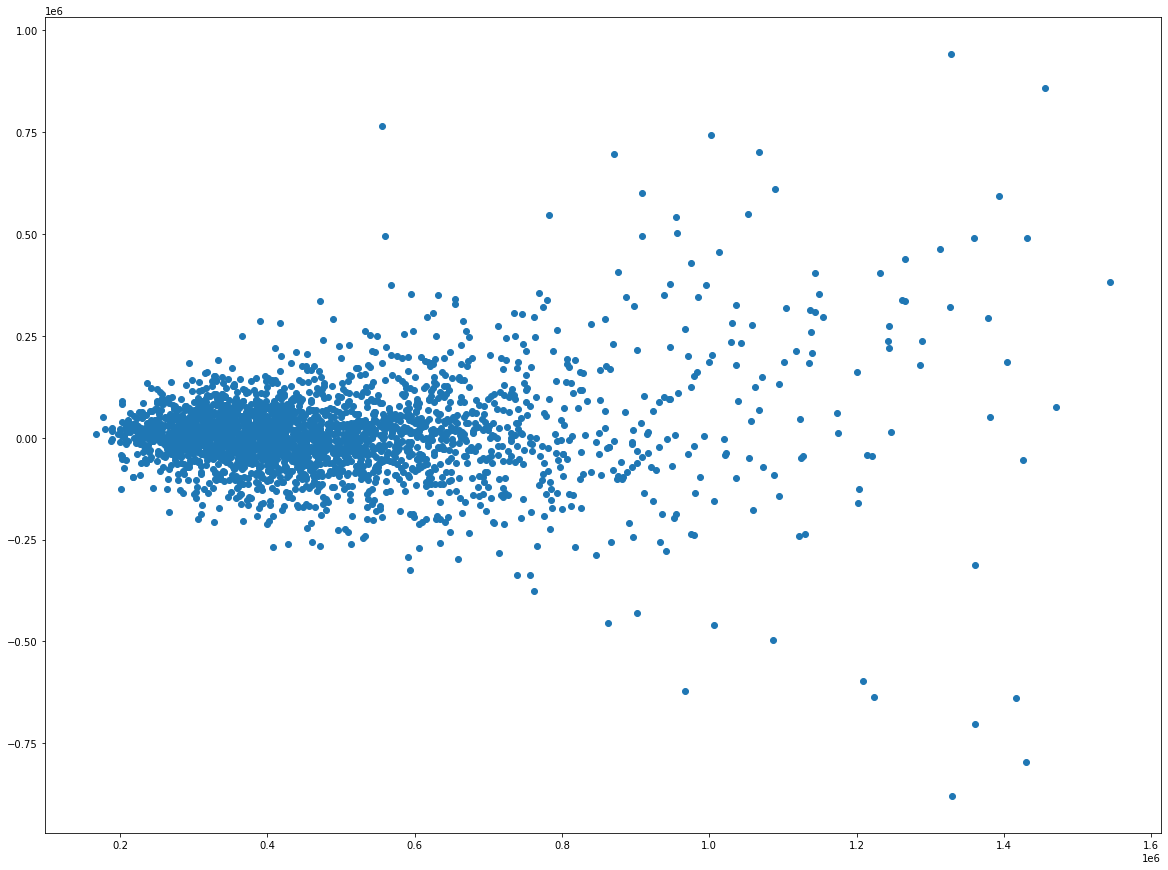

R2:  76.46 
MAE:  73540.92 
RMSE:  115932.24 
108 predictors used for this model


In [30]:
make_model_log(LinearRegression(), X_train_rfecv, X_test_rfecv, y, 'LR w/RFECV, No NLP')

### With NLP

In [31]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression(n_jobs=-4)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-4)

# fit model to train set
rfecv.fit(X_train, y_train)

# make a list of the features used in the rfecv
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['used'] = rfecv.support_
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

In [32]:
# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train[rfecv_result]
X_test_rfecv = X_test[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     187.4
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:19:29   Log-Likelihood:                 1859.1
No. Observations:               10489   AIC:                            -3318.
Df Residuals:                   10289   BIC:                            -1867.
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.6769      0.048    243.693      0.000      11.583      11.771
numPriceChanges         -0.0579      0.002    -27.382      0.000      -0.062      -0.054
lotSizeSqFt              0.0249      0.003      9.304      0.000       0.020       0.030
livingAreaSqFt           0.2178      0.004     59.524      0.000       0.211       0.225
avgSchoolDistance        0.0090      0.003      3.091      0.002       0.003       0.015
avgSchoolRating          0.0545      0.005     11.661      0.000       0.045       0.064
avgSchoolSize           -0.0210      0.005     -4.267      0.000      -0.031      -0.011
numOfStories            -0.0198      0.003     -7.419      0.000      -0.025      -0.015
numOfPhotos              0.0192      0.002      8.042      0.000       0.015       0.024
numOfAppliances          0.0085      0.002      3.814      0.000       0.004       0.013
latest_salemonth        -0.3367      0.003    -99.258      0.000      -0.343      -0.330
zipcode_78660            0.1416      0.048      2.955      0.003       0.048       0.236
zipcode_78701            1.0473      0.098     10.692      0.000       0.855       1.239
zipcode_78702            0.6782      0.035     19.292      0.000       0.609       0.747
zipcode_78703            1.0468      0.035     30.148      0.000       0.979       1.115
zipcode_78704            0.9611      0.031     30.941      0.000       0.900       1.022
zipcode_78705            0.8058      0.044     18.421      0.000       0.720       0.891
zipcode_78717            0.5463      0.047     11.566      0.000       0.454       0.639
zipcode_78721            0.4960      0.036     13.711      0.000       0.425       0.567
zipcode_78722            0.6378      0.039     16.564      0.000       0.562       0.713
zipcode_78723            0.5343      0.032     16.894      0.000       0.472       0.596
zipcode_78724            0.1920      0.035      5.560      0.000       0.124       0.260
zipcode_78725            0.0146      0.033      0.437      0.662      -0.051       0.080
zipcode_78726            0.3253      0.035      9.215      0.000       0.256       0.395
zipcode_78727            0.3644      0.031     11.731      0.000       0.304       0.425
zipcode_78728            0.2437      0.034      7.213      0.000       0.177       0.310
zipcode_78729            0.5430      0.046     11.742      0.000       0.452       0.634
zipcode_78730            0.5748      0.038     15.126      0.000       0.500       0.649
zipcode_78731            0.7626      0.032     23.519      0.000       0.699       0.826
zipcode_78732            0.3517      0.032     10.862      0.000       0.288       0.415
zipcode_78733            0.6316      0.045     13.901      0.000       0.543       0.721
zipcode_78735            0.5835      0.035     16.862    

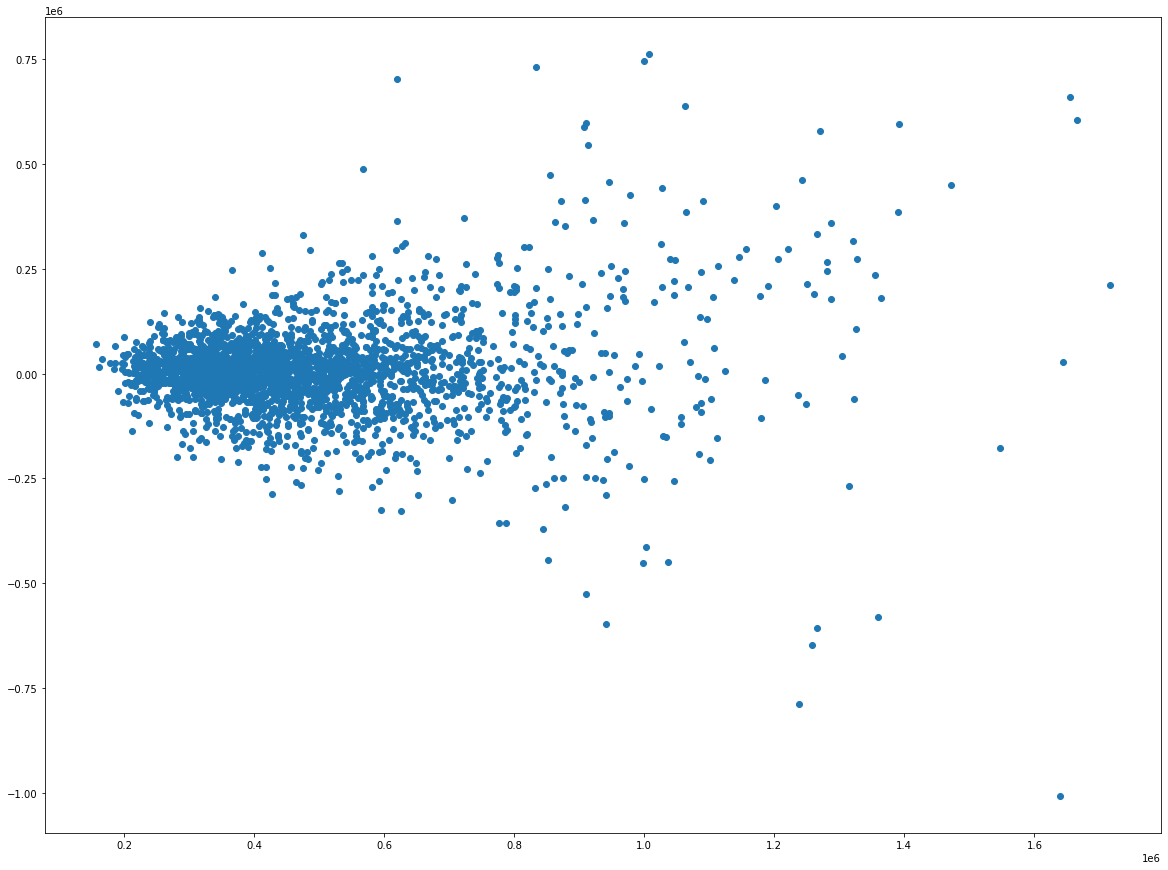

R2:  77.36 
MAE:  71492.51 
RMSE:  112382.16 
200 predictors used for this model


In [33]:
make_model_log(LinearRegression(), X_train_rfecv, X_test_rfecv, y, 'LR w/RFECV')

## XGBoost

We're now going to work with some different model types that are entirely different from linear regression.

There's conflicting information on whether we should use one-hot encoding, or target encoding. We'll solve this by trying both and figuring out what works best for our data set.

We need to slightly redo our one-hot encodings to not drop the first entry. We'll also make year_built into total one-hot encodings rather than bins.

In [34]:
# categoricals with first not dropped for tree
boost_train_cats = pd.get_dummies(df_categoricals, drop_first=False)
boost_test_cats= pd.get_dummies(holdout_categoricals, drop_first=False)

# decision tree regression train and test sets
x_train_boost = pd.concat([x_continuous, boost_train_cats, train_word_vectors_refined], axis=1)
x_test_boost = pd.concat([holdout_continuous, boost_test_cats, holdout_word_vectors_refined], axis=1)

# decision tree regression train and test sets, no NLP
x_train_boost_nonlp = pd.concat([x_continuous, boost_train_cats], axis=1)
x_test_boost_nonlp = pd.concat([holdout_continuous, boost_test_cats], axis=1)

# redoing our y_train and y_test as non-log transformed
#y = df[target] # our target variable

# creating our train/validation sets and our test sets
#y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate)


This model is entirely different than linear regression. Gradient boosting uses decision trees to learn about outcomes, with trees being added to the model one at a time and existing trees in the model are not changed. Each successive tree tries to improve upon the predictions of the first one, with the weights of the various decision points being updated each time. Gradient boosting uses the residuals to improve its next tree prediction. Overall much more opaque of a process than linear regression.

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* n_estimators: Number of boosts to perform. Gradient boosting is pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying things from 2-4 to see what works the best
* min_child_weight: Min sum of instance weight needed in a child
* gamma: Minimum loss reduction to make another partition on a leaf node. Higher results in more conservative algorithm.
* subsample: Ratio of training sets. .5 means that it will sample half the training data before making trees. Occurs with each boosting iteration.
* colsample_by_tree: ratio of columns when making a tree
* alpha: L1 regularization. Higher will make model more conservative.
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

Our parameter tuning for XGBoost is in the APPENDIX

### Without NLP

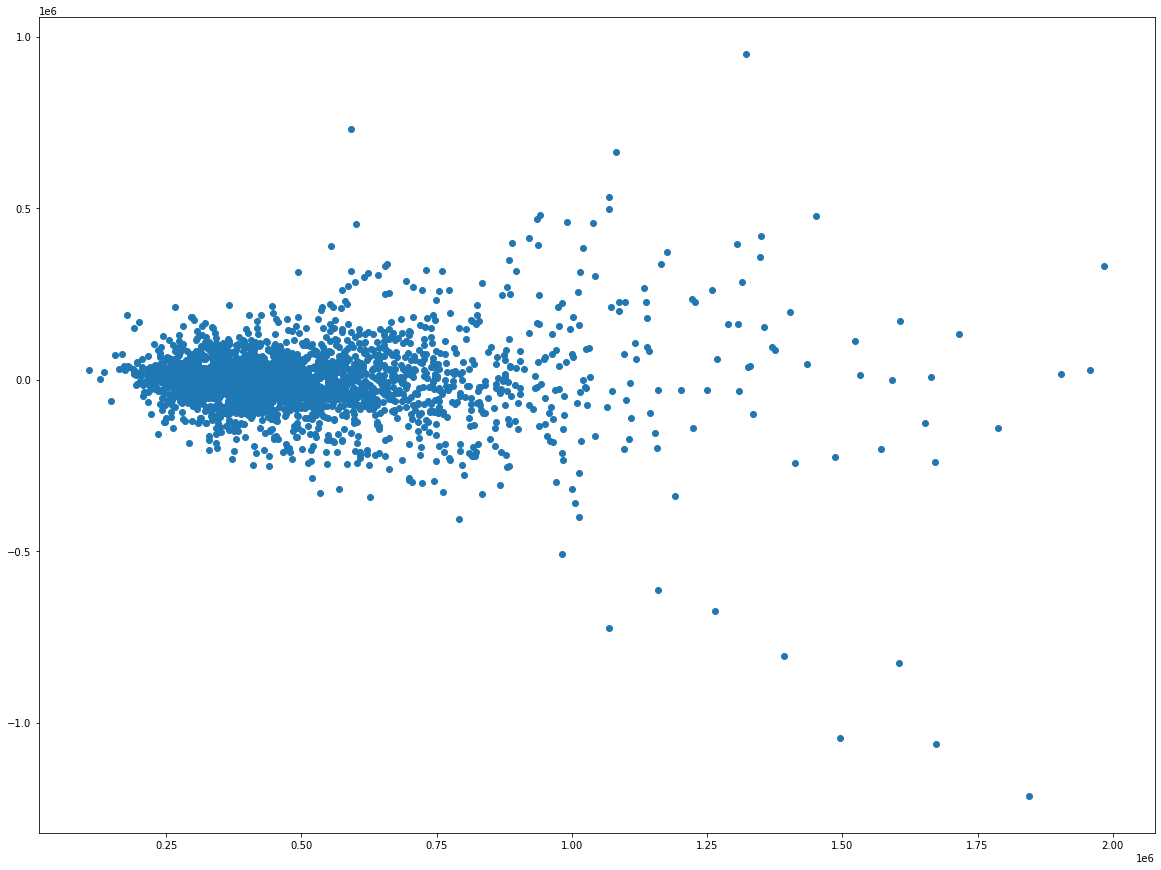

R2:  80.39 
MAE:  67246.78 
RMSE:  109794.87 
129 predictors used for this model


In [35]:
best_xgb_model = xgb.XGBRegressor(
                n_estimators=500,
                max_depth=3,
                learning_rate = .2,
                min_child_weight=7,
                gamma=.005,
                colsample_bytree = .6,
                alpha=1,
                reg_lambda = .1,
                seed=42,
                missing=0,
                eval_metric='mae') 

make_model_nolog(best_xgb_model, x_train_boost_nonlp, x_test_boost_nonlp, y, 'XGB - One-hot - No NLP')

### With NLP

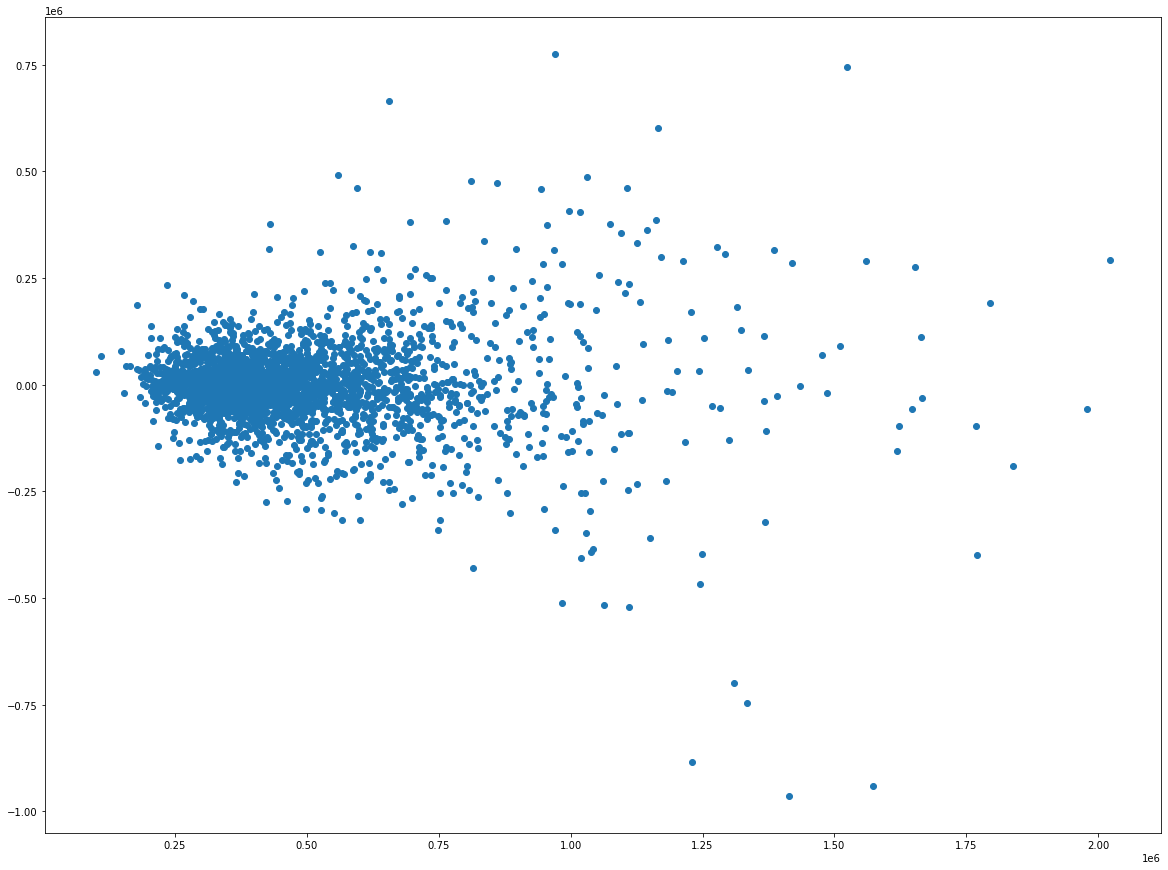

R2:  79.91 
MAE:  67631.03 
RMSE:  107019.56 
223 predictors used for this model


In [36]:
best_xgb_model = xgb.XGBRegressor(
                n_estimators=1000,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=10,
                gamma=.01,
                subsample = .8,
                colsample_bytree = .6,
                alpha=1,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae') 
 

make_model_nolog(best_xgb_model, x_train_boost, x_test_boost, y, 'XGB - One-hot')

# Model Selection

We ran several different types of models, and logged the r^squared and mean absolute error for each model type. Which model performed the best for us?

In [37]:
# make data frame from our models dictionary
model_types = pd.DataFrame(models)

# sort data frame by mae and reset index
model_types = model_types.sort_values('mae', ascending=True).reset_index()
model_types.drop('index',axis=1, inplace=True)
model_types.set_index('Models', inplace=True)

model_types

,r2,mae,rmse
Models,,,
XGB - One-hot - No NLP,80.39,67246.78,109794.87
XGB - One-hot,79.91,67631.03,107019.56
LR w/RFECV,77.36,71492.51,112382.16
"LR w/RFECV, No NLP",76.46,73540.92,115932.24


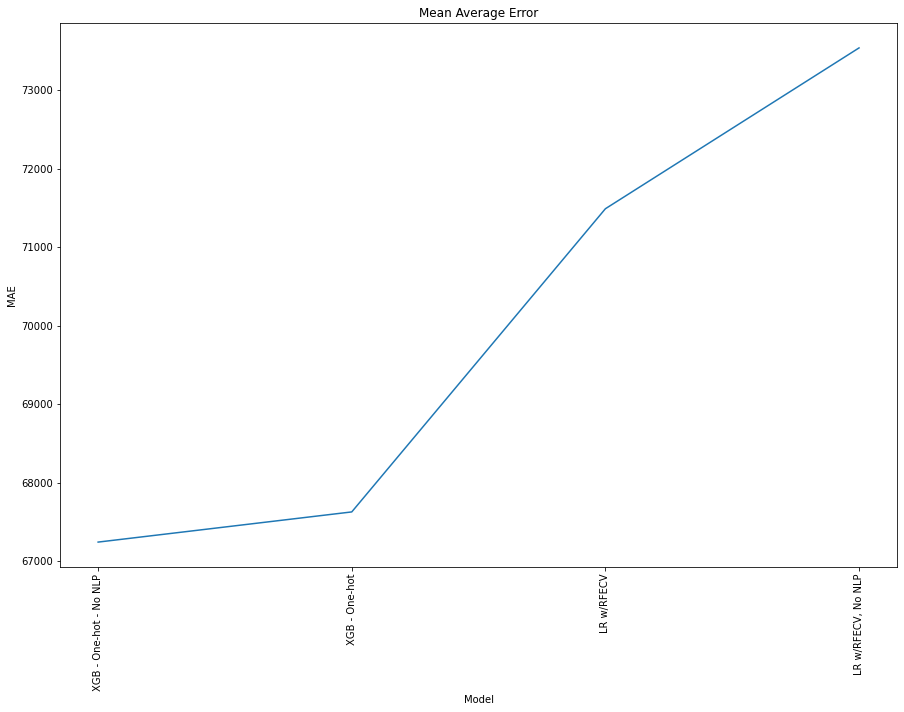

In [38]:
# plot model mae

plt.figure(figsize=(15,10))
plt.plot(model_types['mae'])
plt.title("Mean Average Error")
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel("MAE");

Ultimately we will select the sklearn SVM method for our model. Support Vector Machine's explicit goal to minimize absolute error coordinates nicely with price predictions.

In [39]:
break

SyntaxError: 'break' outside loop (<ipython-input-39-6aaf1f276005>, line 1)

# APPENDIX

## XGBoost - W/NLP Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,20,2), 
                                               cv=5, scoring='r2', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,20,2), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,20,2), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
# Parameter Tuning max_depth

param_grid = {"max_depth": [4,5,6,]
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 4}

    Grid scores on train set:

    0.777 (+/-0.011) for {'max_depth': 4}
    0.772 (+/-0.006) for {'max_depth': 5}
    0.767 (+/-0.014) for {'max_depth': 6}

In [ ]:
# Parameter Tuning learning_rate

param_grid = {"learning_rate" : [.005, .01, .05, .1, .2, .3, .5]  
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'learning_rate': 0.1}

    Grid scores on train set:

    -66.909 (+/-3.005) for {'learning_rate': 0.005}
    -4.820 (+/-0.198) for {'learning_rate': 0.01}
    0.767 (+/-0.014) for {'learning_rate': 0.05}
    0.783 (+/-0.011) for {'learning_rate': 0.1}
    0.780 (+/-0.014) for {'learning_rate': 0.2}
    0.777 (+/-0.011) for {'learning_rate': 0.3}
    0.749 (+/-0.013) for {'learning_rate': 0.5}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [6, 8, 10]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                learning_rate = .1,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 10}

    Grid scores on train set:

    0.782 (+/-0.011) for {'min_child_weight': 6}
    0.783 (+/-0.011) for {'min_child_weight': 8}
    0.784 (+/-0.012) for {'min_child_weight': 10}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [9, 10, 11, 13]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                learning_rate = .1,
                 max_depth=4,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 10}

    Grid scores on train set:

    0.783 (+/-0.012) for {'min_child_weight': 9}
    0.784 (+/-0.012) for {'min_child_weight': 10}
    0.783 (+/-0.012) for {'min_child_weight': 11}
    0.784 (+/-0.013) for {'min_child_weight': 13}

In [ ]:
# Parameter Tuning gamma

param_grid = {'gamma':[.005, .01, .05, .1, .3, .5, 1]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=10,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.1}

    Grid scores on train set:

    0.784 (+/-0.012) for {'gamma': 0.005}
    0.784 (+/-0.011) for {'gamma': 0.01}
    0.783 (+/-0.011) for {'gamma': 0.05}
    0.784 (+/-0.011) for {'gamma': 0.1}
    0.776 (+/-0.012) for {'gamma': 0.3}
    0.770 (+/-0.016) for {'gamma': 0.5}
    0.755 (+/-0.019) for {'gamma': 1}

In [ ]:
# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=10,
                gamma=.01,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 
    
    {'subsample': 0.8}

    Grid scores on train set:

    0.769 (+/-0.012) for {'subsample': 0.2}
    0.779 (+/-0.012) for {'subsample': 0.4}
    0.784 (+/-0.011) for {'subsample': 0.6}
    0.784 (+/-0.011) for {'subsample': 0.8}
    0.784 (+/-0.011) for {'subsample': 1}

In [ ]:
# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=10,
                subsample = .8,
                gamma=.01,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.6}

    Grid scores on train set:

    0.785 (+/-0.014) for {'colsample_bytree': 0.2}
    0.785 (+/-0.012) for {'colsample_bytree': 0.4}
    0.785 (+/-0.012) for {'colsample_bytree': 0.6}
    0.785 (+/-0.010) for {'colsample_bytree': 0.8}
    0.784 (+/-0.011) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[0.1, 1, 10, 100, 250, 500]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=10,
                gamma=.01,
                colsample_bytree = .6,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 1}

    Grid scores on train set:

    0.785 (+/-0.011) for {'reg_alpha': 0.1}
    0.786 (+/-0.011) for {'reg_alpha': 1}
    0.771 (+/-0.020) for {'reg_alpha': 10}
    0.657 (+/-0.018) for {'reg_alpha': 100}
    0.524 (+/-0.024) for {'reg_alpha': 250}
    0.427 (+/-0.020) for {'reg_alpha': 500}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 500, 1000, 2500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=10,
                gamma=.01,
                subsample = .8,
                colsample_bytree = .6,
                alpha=1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 1}
    
    Grid scores on train set:

    0.785 (+/-0.013) for {'lambda': 0.1}
    0.786 (+/-0.012) for {'lambda': 1}
    0.785 (+/-0.011) for {'lambda': 10}
    0.778 (+/-0.017) for {'lambda': 100}
    0.765 (+/-0.017) for {'lambda': 500}
    0.751 (+/-0.014) for {'lambda': 1000}
    0.718 (+/-0.014) for {'lambda': 2500}

In [ ]:
# Parameter Tuning num_estimators

param_grid = {'n_estimators':[250, 500, 1000, 5000]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=4,
                learning_rate = .1,
                min_child_weight=10,
                gamma=.01,
                subsample = .8,
                colsample_bytree = .6,
                alpha=1,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae') 

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'n_estimators': 1000}

    Grid scores on train set:

    0.786 (+/-0.012) for {'n_estimators': 250}
    0.794 (+/-0.012) for {'n_estimators': 500}
    0.795 (+/-0.013) for {'n_estimators': 1000}
    0.786 (+/-0.010) for {'n_estimators': 5000}

## XGBoost - Without  NLP Tuning

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(1,20,2), 
                                               cv=5, scoring='r2', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1,20,2), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(1,20,2), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost_nonlp, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
# Parameter Tuning max_depth

param_grid = {"max_depth": [3, 4,5,6,]
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'max_depth': 3}

    Grid scores on train set:

    0.787 (+/-0.013) for {'max_depth': 3}
    0.783 (+/-0.013) for {'max_depth': 4}
    0.779 (+/-0.011) for {'max_depth': 5}
    0.769 (+/-0.019) for {'max_depth': 6}

In [ ]:
# Parameter Tuning learning_rate

param_grid = {"learning_rate" : [.005, .01, .05, .1, .2, .3, .5]  
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                 max_depth=3,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'learning_rate': 0.2}

    Grid scores on train set:

    -66.913 (+/-2.998) for {'learning_rate': 0.005}
    -4.845 (+/-0.186) for {'learning_rate': 0.01}
    0.754 (+/-0.015) for {'learning_rate': 0.05}
    0.778 (+/-0.015) for {'learning_rate': 0.1}
    0.788 (+/-0.014) for {'learning_rate': 0.2}
    0.787 (+/-0.013) for {'learning_rate': 0.3}
    0.775 (+/-0.005) for {'learning_rate': 0.5}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [6, 8, 10]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                learning_rate = .2,
                 max_depth=3,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 8}

    Grid scores on train set:

    0.790 (+/-0.014) for {'min_child_weight': 6}
    0.791 (+/-0.011) for {'min_child_weight': 8}
    0.790 (+/-0.013) for {'min_child_weight': 10}

In [ ]:
# Parameter Tuning max_depth and min_child_weight

param_grid = {"min_child_weight" : [7,8,9]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,
                learning_rate = .2,
                 max_depth=3,
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'min_child_weight': 7}

    Grid scores on train set:

    0.791 (+/-0.013) for {'min_child_weight': 7}
    0.791 (+/-0.011) for {'min_child_weight': 8}
    0.790 (+/-0.013) for {'min_child_weight': 9}

In [ ]:
# Parameter Tuning gamma

param_grid = {'gamma':[.005, .01, .05, .1, .3, .5, 1]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=3,
                learning_rate = .2,
                min_child_weight=7,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'gamma': 0.005}

    Grid scores on train set:

    0.790 (+/-0.013) for {'gamma': 0.005}
    0.790 (+/-0.013) for {'gamma': 0.01}
    0.790 (+/-0.011) for {'gamma': 0.05}
    0.786 (+/-0.012) for {'gamma': 0.1}
    0.773 (+/-0.013) for {'gamma': 0.3}
    0.764 (+/-0.015) for {'gamma': 0.5}
    0.749 (+/-0.016) for {'gamma': 1}

In [ ]:
# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=3,
                learning_rate = .2,
                min_child_weight=7,
                gamma=.005,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'subsample': 1}

    Grid scores on train set:

    0.764 (+/-0.007) for {'subsample': 0.2}
    0.776 (+/-0.010) for {'subsample': 0.4}
    0.789 (+/-0.014) for {'subsample': 0.6}
    0.787 (+/-0.013) for {'subsample': 0.8}
    0.790 (+/-0.013) for {'subsample': 1}

In [ ]:
# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=3,
                learning_rate = .2,
                min_child_weight=7,
                gamma=.005,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'colsample_bytree': 0.6}

    Grid scores on train set:

    0.790 (+/-0.016) for {'colsample_bytree': 0.2}
    0.790 (+/-0.015) for {'colsample_bytree': 0.4}
    0.791 (+/-0.014) for {'colsample_bytree': 0.6}
    0.790 (+/-0.014) for {'colsample_bytree': 0.8}
    0.790 (+/-0.013) for {'colsample_bytree': 1}

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[0.1, 1, 10, 100, 250, 500]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=3,
                learning_rate = .2,
                min_child_weight=7,
                gamma=.005,
                colsample_bytree = .6,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 1}

    Grid scores on train set:

    0.791 (+/-0.012) for {'reg_alpha': 0.1}
    0.791 (+/-0.015) for {'reg_alpha': 1}
    0.767 (+/-0.019) for {'reg_alpha': 10}
    0.635 (+/-0.019) for {'reg_alpha': 100}
    0.502 (+/-0.017) for {'reg_alpha': 250}
    0.401 (+/-0.020) for {'reg_alpha': 500}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 500, 1000, 2500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=3,
                learning_rate = .2,
                min_child_weight=7,
                gamma=.005,
                colsample_bytree = .6,
                alpha=1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 0.1}

    Grid scores on train set:

    0.791 (+/-0.017) for {'lambda': 0.1}
    0.791 (+/-0.015) for {'lambda': 1}
    0.786 (+/-0.013) for {'lambda': 10}
    0.780 (+/-0.017) for {'lambda': 100}
    0.768 (+/-0.018) for {'lambda': 500}
    0.763 (+/-0.015) for {'lambda': 1000}
    0.744 (+/-0.015) for {'lambda': 2500}

In [ ]:
# Parameter Tuning num_estimators

param_grid = {'n_estimators':[250, 500, 1000, 5000]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth=3,
                learning_rate = .2,
                min_child_weight=7,
                gamma=.005,
                colsample_bytree = .6,
                alpha=1,
                reg_lambda = .1,
                seed=42,
                missing=0,
                eval_metric='mae') 

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost_nonlp, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'n_estimators': 500}

    Grid scores on train set:

    0.791 (+/-0.017) for {'n_estimators': 250}
    0.796 (+/-0.014) for {'n_estimators': 500}
    0.793 (+/-0.012) for {'n_estimators': 1000}
    0.788 (+/-0.010) for {'n_estimators': 5000}